In [55]:

import cv2
import matplotlib.image as mpimg
import numpy as np
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [56]:
import glob
import pickle

import cv2
import numpy as np
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.pooling import AveragePooling2D
from keras.models import Sequential
from keras.models import model_from_json
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

In [57]:
import glob
import pickle
import time

import cv2
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json
from moviepy.editor import VideoFileClip
from skimage.feature import hog

from detect_car_utils import slide_window, add_heat, apply_threshold, get_labeled_bboxes, draw_boxes, find_matches, get_windows_to_search_cars_in
from detect_cars_using_svc import get_hog_features
import matplotlib.pyplot as plt

detect_cars_using_svc.py defines methods to extract HOG features and train the model using svn. I tried differnt values of color spaces from HLS, YCrCb, RGB to YUV and finally used YUV with HOG features calculated with orientation of 17, 8 pixel per cell and 2 cells per block to get an optimal number of HOG features to get somewhat better results. `extract_features` extracts all the features given an image to be used for training. `get_hog_features` calculates the HOG features for the image  

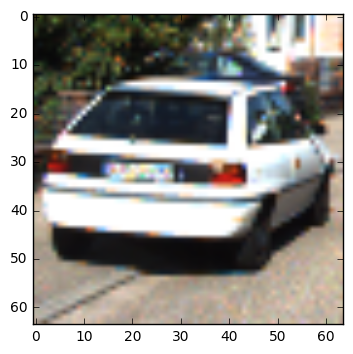

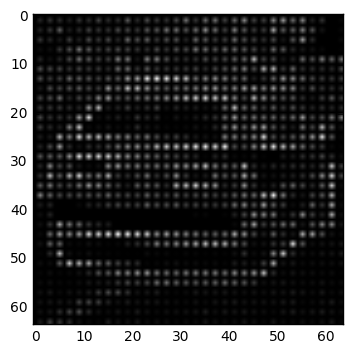

In [58]:
car_image = mpimg.imread("./data/vehicles/KITTI_extracted/17.png")
features, car_image_hog = get_hog_features(car_image[:,:,0], 15, 2, 1, True, True)
plt.imshow(car_image)
plt.show()
plt.imshow(car_image_hog, cmap="gray")
plt.show()

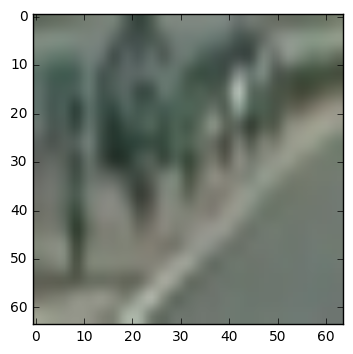

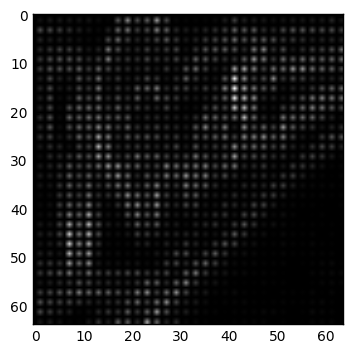

In [59]:
car_image = mpimg.imread("./data/non-vehicles/GTI/image44.png")
features, car_image_hog = get_hog_features(car_image[:,:,0], 15, 2, 1, True, True)
plt.imshow(car_image)
plt.show()
plt.imshow(car_image_hog, cmap="gray")
plt.show()

However, I was getting too many false positives even in every frame and I had to consider multiple past frames to get a heat map to reduce them. This was slowing the car search down and also I was not getting the expected results. So I decided to try another approach. I used CNN to train the classifier.

`detect_cars_using_cnn.py` defines a binary classifier CNN (`get_keras_model`) that takes a 64x64x3 image as an input and gives a probability of it being a car or not. While trainig this CNN as well, when I used RGB color space I was getting significant false positives, but was much less than what I got using HOG features and SVC. Then I tried different color spaces in the CNN and got best results using YUV color space. The advantage of using CNN was, I did not have to calcuate HOG features which (I observed to be a bit slow) and could use just the image itself as feature data.

In order to detect the car in an image, I used the sliding window technique. I defined five different sizes of windows and a separate start and end position for each of them (`get_windows_to_search_cars_in` in `detect_car_utils.py`). This gave me about 480 differrent windows to look into.

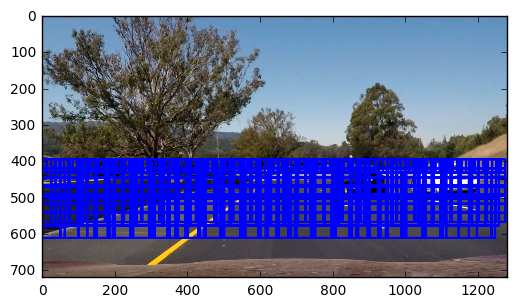

In [60]:
image = mpimg.imread("./test_images/test6.jpg")
bboxes = get_windows_to_search_cars_in(image)
image_with_all_windows = draw_boxes(image, bboxes)
plt.imshow(image_with_all_windows)
plt.show()

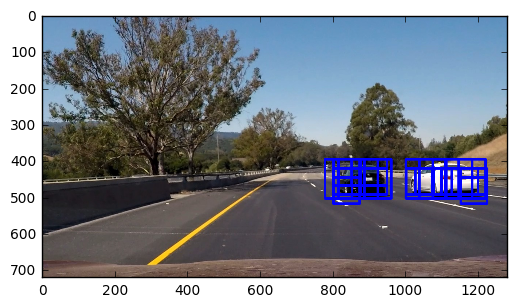

In [61]:
from detect_cars_using_cnn import normalize_data

with open('./model.json', 'r') as jfile:
    model = model_from_json(jfile.read())
    model.compile('adam', 'binary_crossentropy', ['accuracy'])
    model.load_weights("./model.h5")

windows = get_windows_to_search_cars_in(image)
cars = []
image_features = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
for window in windows:
    cropped_image = image_features[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    features = normalize_data(cv2.resize(cropped_image, (64, 64)))
    array = np.array([features])
    prediction = model.predict(array, batch_size=1)
    if prediction > 0.80:
        cars.append(window)

image_with_cars = draw_boxes(image, cars)
plt.imshow(image_with_cars)
plt.show()

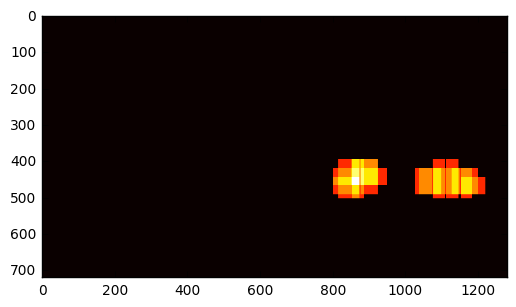

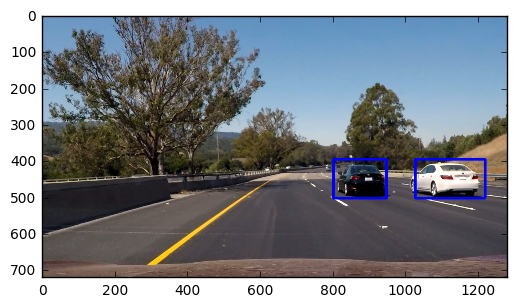

In [62]:
from detect_car_utils import add_heat, apply_threshold
heat = np.zeros_like(image[:, :, 0]).astype(np.float)
heat = add_heat(heat, cars)
heat = apply_threshold(heat, 2)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
bboxes = get_labeled_bboxes(image, labels)
plt.imshow(heatmap, cmap="hot")
plt.show()
final_image_with_cars = draw_boxes(image, bboxes)
plt.imshow(final_image_with_cars)
plt.show()

In oder to remove the false positive and add consider false negatives I used combination of detecting a car using a classifier and template matching. Once I find a car in an image using classifier, I store it's location in an array for past 2 frames (towards the end of `mark_cars_using_cnn` in `detect_cars_using_cnn.py`). I then use these as templates and try to find them in the current image (`find_matches` in `detect_car_utils.py`) and add them to the list of detected cars for the current image.

The final processed video is available as `project_video_processed.mp4` in the provided zip file